In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
#Data preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [3]:
#Models and their evaluations
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, classification_report, f1_score, make_scorer, precision_score, recall_score
from sklearn.metrics import balanced_accuracy_score as accuracy_score
import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import optuna
from sklearn.model_selection import StratifiedKFold

In [4]:
#visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#other important librares
import numpy as np
import shap
import glob
import os
from joblib import dump

# WEB-IDS23 Dataset

### Mix into one file

In [6]:
data_folder = "csv/web-ids23/"

file_names = [
    "web-ids23_bruteforce_http.csv",
    "web-ids23_bruteforce_https.csv",
    "web-ids23_dos_https.csv",
    "web-ids23_portscan.csv",
    "web-ids23_sql_injection_http.csv",
    "web-ids23_sql_injection_https.csv",
    "web-ids23_ssh_login.csv",
    "web-ids23_ssh_login_successful.csv",
    "web-ids23_ssrf_http.csv",
    "web-ids23_ssrf_https.csv",
    "web-ids23_xss_http.csv",
    "web-ids23_xss_https.csv",
    "web-ids23_revshell_http.csv",
    "web-ids23_revshell_https.csv",
    "web-ids23_smtp_enum.csv",
    "web-ids23_smtp_version.csv",
    "web-ids23_hostsweep_Pn.csv",
    "web-ids23_hostsweep_sn.csv",
    "web-ids23_ftp_login.csv",
    "web-ids23_ftp_version.csv",
    "web-ids23_dos_http.csv"
]

dataframes = []
min_rows = 100
    
for file in file_names:
    df = pd.read_csv(os.path.join(data_folder, file))
    df_sampled = df.sample(n=min(min_rows,len(df)), random_state=42) 
    dataframes.append(df_sampled)
    
df = pd.read_csv(os.path.join(data_folder, "web-ids23_benign.csv"))
df_sampled = df.sample(n=min(8000,len(df)), random_state=42) 
dataframes.append(df_sampled)

combined_df = pd.concat(dataframes, ignore_index=True)

output_path = "csv\\webids23.csv"
combined_df.to_csv(output_path, index=False)


In [7]:
len(combined_df)

10007

In [8]:
#Data pre-processing
file_path = 'csv\\webids23.csv'
data = pd.read_csv(file_path)

label_encoder = LabelEncoder()
data['attack'] = label_encoder.fit_transform(data['attack'])
data['id.orig_h'] = label_encoder.fit_transform(data['id.orig_h'])  
data['id.resp_h'] = label_encoder.fit_transform(data['id.resp_h']) 
data['service'] = label_encoder.fit_transform(data['service']) 
data['traffic_direction'] = label_encoder.fit_transform(data['traffic_direction']) 


features = [
    'id.orig_h',
    'id.resp_h',
    'service',
    'flow_duration',
    'fwd_pkts_tot',
    'bwd_pkts_tot',
    'fwd_data_pkts_tot',
    'bwd_data_pkts_tot',
    'fwd_pkts_per_sec',
    'bwd_pkts_per_sec',
    'flow_pkts_per_sec',
    'down_up_ratio',
    'fwd_header_size_tot',
    'fwd_header_size_min',
    'fwd_header_size_max',
    'bwd_header_size_tot',
    'bwd_header_size_min',
    'bwd_header_size_max',
    'flow_FIN_flag_count',
    'flow_SYN_flag_count',
    'flow_RST_flag_count',
    'fwd_PSH_flag_count',
    'bwd_PSH_flag_count',
    'flow_ACK_flag_count',
    'fwd_URG_flag_count',
    'bwd_URG_flag_count',
    'flow_CWR_flag_count',
    'flow_ECE_flag_count',
    'payload_bytes_per_second',
    'fwd_init_window_size',
    'bwd_init_window_size',
    'fwd_last_window_size',
    'bwd_last_window_size',
    'traffic_direction'
]
X = data[features]
y = data['attack']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Accuracy: 0.9813059701492537
Confusion Matrix: [[ 393    9]
 [  24 1576]]


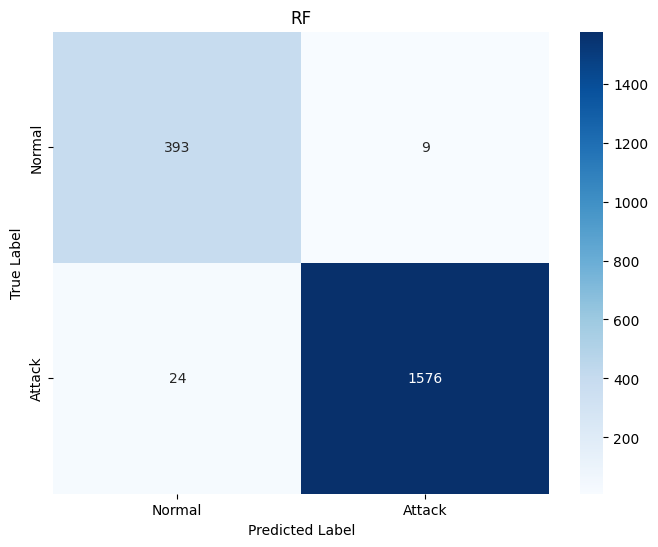

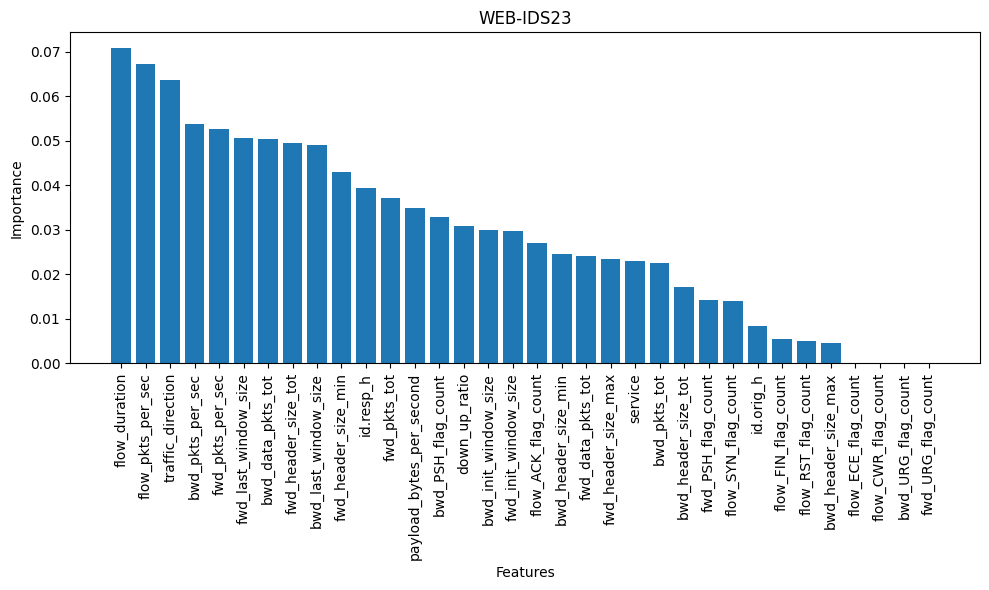

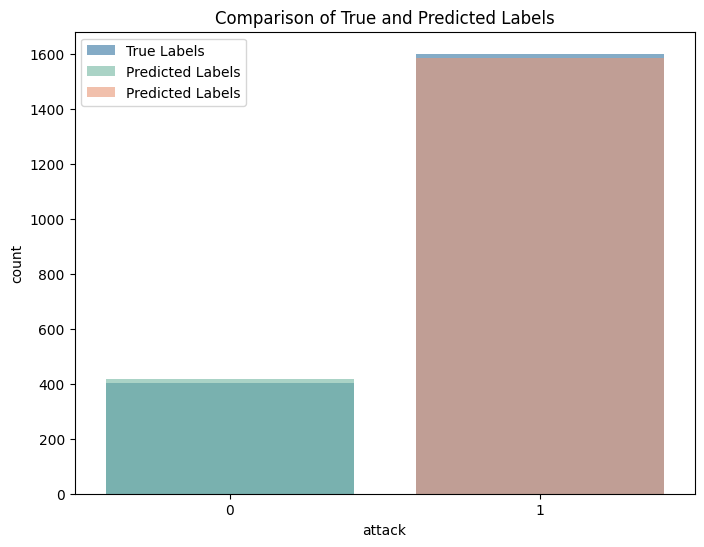

In [9]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

#Results
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

#Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("RF")
plt.show()

feature_importances = clf.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.title("WEB-IDS23")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, label="True Labels", alpha=0.6)
sns.countplot(x=y_pred, label="Predicted Labels", alpha=0.6, palette="Set2")
plt.legend()
plt.title("Comparison of True and Predicted Labels")
plt.show()

In [10]:
del clf

### Read and pre-proccess the united dataset

In [11]:
#Data pre-processing
file_path = 'csv\\webids23.csv'
data = pd.read_csv(file_path)

label_encoder = LabelEncoder()
data['attack'] = label_encoder.fit_transform(data['attack'])

features = ['flow_duration', 'flow_pkts_per_sec','bwd_data_pkts_tot','fwd_pkts_tot','fwd_header_size_tot']

X = data[features]
y = data['attack']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Random Forest

In [12]:
#Random Forest
param_grid = {
    'n_estimators': [10, 30, 50, 100, 200],
    'max_depth': [None, 10, 20, 30, 50], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4], 
    'max_features': ['sqrt', 'log2', None]
}

rf_model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='balanced_accuracy', cv=5, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)

optimized_rf_model = RandomForestClassifier(**best_params, random_state=42)
optimized_rf_model.fit(X_train, y_train)

y_pred = optimized_rf_model.predict(X_test)

Fitting 5 folds for each of 675 candidates, totalling 3375 fits
Best Parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}
Best Cross-Validation Accuracy: 0.953390284267913


In [13]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

Accuracy: 0.9588805970149253
Confusion Matrix: [[ 381   21]
 [  48 1552]]


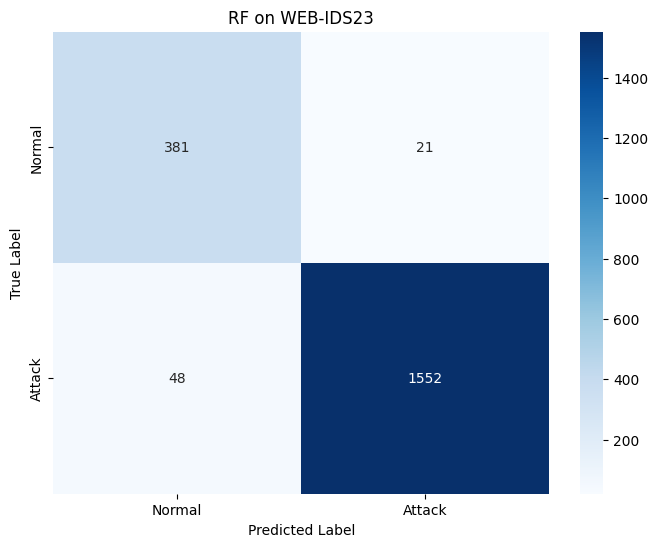

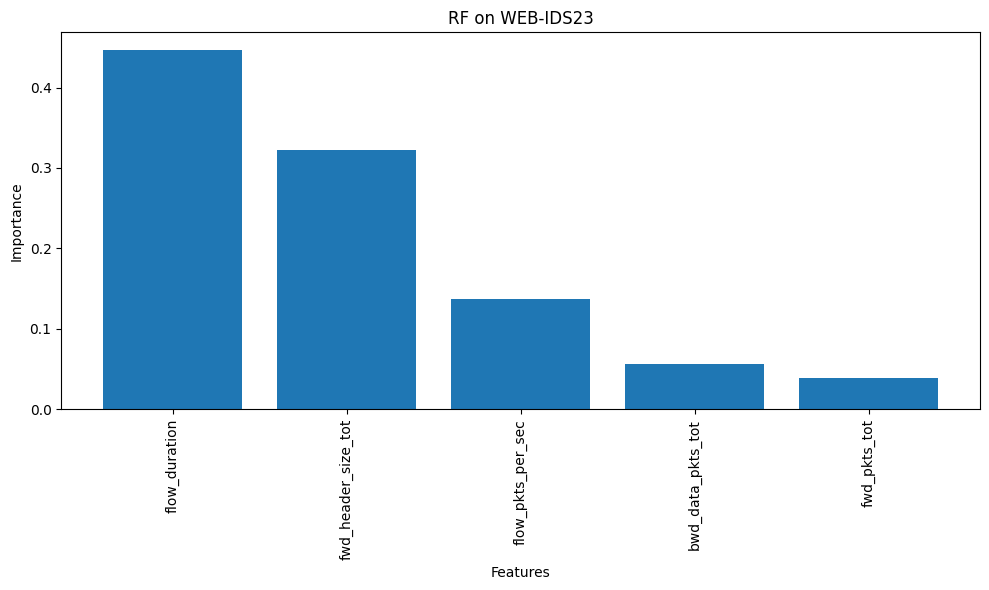

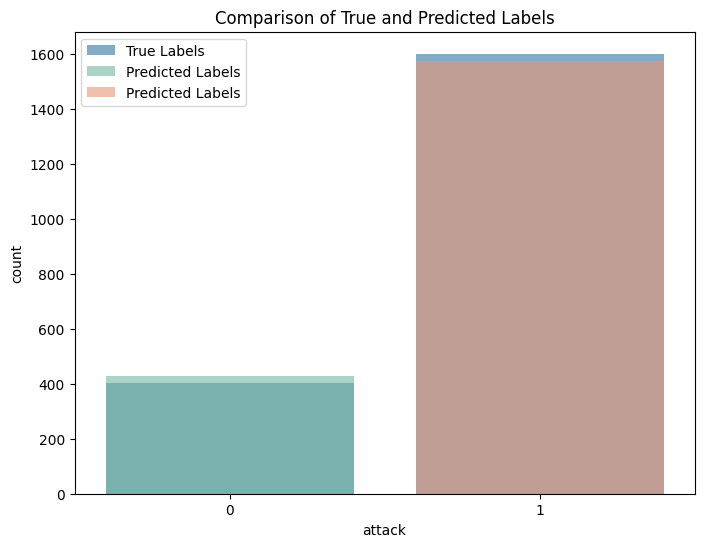

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("RF on WEB-IDS23")
plt.show()

feature_importances = optimized_rf_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.title("RF on WEB-IDS23")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, label="True Labels", alpha=0.6)
sns.countplot(x=y_pred, label="Predicted Labels", alpha=0.6, palette="Set2")
plt.legend()
plt.title("Comparison of True and Predicted Labels")
plt.show()

In [15]:
dump(optimized_rf_model, "models\\rf_model.joblib", compress=("xz", 3))

['models\\rf_model.joblib']

In [16]:
del optimized_rf_model
del rf_model

### Support Vector Machine

In [17]:
#SVM
svm_model = SVC(kernel='linear', random_state=42) 
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

In [18]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

Accuracy: 0.8221595149253731
Confusion Matrix: [[ 306   96]
 [ 187 1413]]


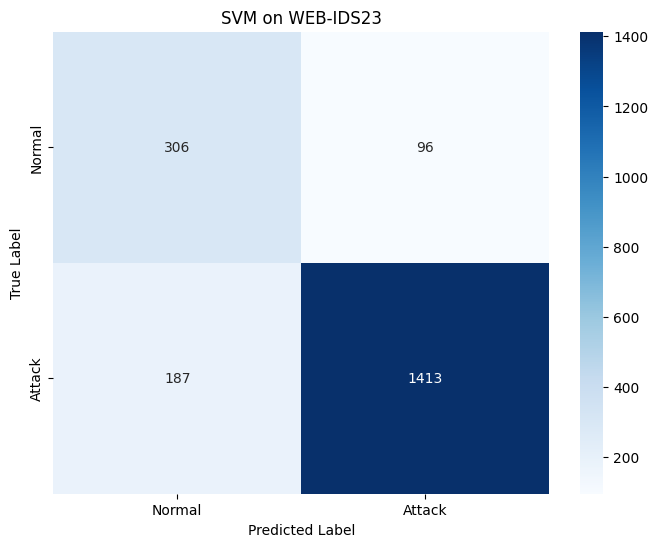

AttributeError: 'SVC' object has no attribute 'feature_importances_'

In [21]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("SVM on WEB-IDS23")
plt.show()

feature_importances = svm_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.title("SVM on WEB-IDS23")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, label="True Labels", alpha=0.6)
sns.countplot(x=y_pred, label="Predicted Labels", alpha=0.6, palette="Set2")
plt.legend()
plt.title("Comparison of True and Predicted Labels")
plt.show()

In [22]:
dump(svm_model, "models\\svm_model.joblib", compress=("xz", 3))

['models\\svm_model.joblib']

In [ ]:
del svm_model

### Gradient Boosting Machine

In [23]:
#GBM
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

gbm = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, scoring='balanced_accuracy', cv=5, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)

optimized_gbm_model = GradientBoostingClassifier(**best_params, random_state=42)
optimized_gbm_model.fit(X_train, y_train)

y_pred = optimized_gbm_model.predict(X_test)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


KeyboardInterrupt: 

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("GBM on WEB-IDS23")
plt.show()

feature_importances = optimized_gbm_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.title("GBM on WEB-IDS23")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, label="True Labels", alpha=0.6)
sns.countplot(x=y_pred, label="Predicted Labels", alpha=0.6, palette="Set2")
plt.legend()
plt.title("Comparison of True and Predicted Labels")
plt.show()

In [ ]:
dump(optimized_gbm_model, "models\\gbm_model.joblib", compress=("xz", 3))

In [ ]:
del optimized_gbm_model
del gbm

### LightGBM

In [ ]:
#lightGBM
param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
}

model = lgb.LGBMClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

optimized_lgb_model = grid_search.best_estimator_
y_pred = optimized_lgb_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("LightGBM on WEB-IDS23")
plt.show()

feature_importances = optimized_lgb_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.title("LightGBM on WEB-IDS23")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, label="True Labels", alpha=0.6)
sns.countplot(x=y_pred, label="Predicted Labels", alpha=0.6, palette="Set2")
plt.legend()
plt.title("Comparison of True and Predicted Labels")
plt.show()

In [ ]:
optimized_lgb_model.booster_.save_model('models\\lgb_model_gcv.txt')

In [ ]:
def objective(trial):
    params = {
        'random_state': 42,
        'num_leaves': trial.suggest_categorical('num_leaves', [31, 50, 70, 100]),
        'max_depth': trial.suggest_categorical('max_depth', [-1, 10, 20, 30]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1]),
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 500]),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [10, 20, 30]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.8, 1.0]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6, 0.8, 1.0]),
        'reg_alpha': trial.suggest_categorical('reg_alpha', [0.0, 0.1, 0.5]),
        'reg_lambda': trial.suggest_categorical('reg_lambda', [0.0, 0.1, 0.5])
    }

    model = lgb.LGBMClassifier(**params)
    
    # Keresztvalidálás (5-fold Stratified)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, valid_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds)
        f1_scores.append(f1)

    return sum(f1_scores) / len(f1_scores)

# Optuna keresés indítása
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Legjobb modell újratanítása teljes train szetten
best_params = study.best_params
best_params['random_state'] = 42
optimized_lgb_model = lgb.LGBMClassifier(**best_params)
optimized_lgb_model.fit(X_train, y_train)

# Előrejelzés teszt adaton
y_pred = optimized_lgb_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("LightGBM on WEB-IDS23")
plt.show()

feature_importances = optimized_lgb_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.title("LightGBM on WEB-IDS23")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, label="True Labels", alpha=0.6)
sns.countplot(x=y_pred, label="Predicted Labels", alpha=0.6, palette="Set2")
plt.legend()
plt.title("Comparison of True and Predicted Labels")
plt.show()

In [ ]:
optimized_lgb_model.booster_.save_model('models\\lgb_model_optuna.txt')

In [ ]:
del optimized_lgb_model

### CatBoost

In [ ]:
param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6, 8]
}

model = CatBoostClassifier(verbose=0, random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

optimized_catboost_model = grid_search.best_estimator_
y_pred = optimized_catboost_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("LightGBM on WEB-IDS23")
plt.show()

feature_importances = optimized_catboost_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.title("LightGBM on WEB-IDS23")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, label="True Labels", alpha=0.6)
sns.countplot(x=y_pred, label="Predicted Labels", alpha=0.6, palette="Set2")
plt.legend()
plt.title("Comparison of True and Predicted Labels")
plt.show()

In [ ]:
optimized_catboost_model.save_model("models\\catboost_model_gcv.cbm")

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_categorical('iterations', [100, 200, 500, 1000]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.03, 0.05, 0.1]),
        'depth': trial.suggest_categorical('depth', [4, 6, 8, 10]),
        'l2_leaf_reg': trial.suggest_categorical('l2_leaf_reg', [1, 3, 5, 7, 10]),
        'border_count': trial.suggest_categorical('border_count', [32, 64, 128]),
        'bagging_temperature': trial.suggest_categorical('bagging_temperature', [0, 0.5, 1.0]),
        'random_strength': trial.suggest_categorical('random_strength', [0.5, 1, 2]),
        'rsm': trial.suggest_categorical('rsm', [0.8, 1.0]),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Plain', 'Ordered']),
        'random_state': 42,
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    f1_scores = []
    for train_idx, valid_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds)
        f1_scores.append(f1)

    return sum(f1_scores) / len(f1_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

best_params = study.best_params
best_params['random_state'] = 42
best_params['verbose'] = 0
optimized_catboost_model = CatBoostClassifier(**best_params)
optimized_catboost_model.fit(X_train, y_train)

y_pred = optimized_catboost_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("LightGBM on WEB-IDS23")
plt.show()

feature_importances = optimized_catboost_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.title("LightGBM on WEB-IDS23")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, label="True Labels", alpha=0.6)
sns.countplot(x=y_pred, label="Predicted Labels", alpha=0.6, palette="Set2")
plt.legend()
plt.title("Comparison of True and Predicted Labels")
plt.show()

In [ ]:
optimized_catboost_model.save_model("models\\catboost_model_optuna.cbm")

In [ ]:
del optimized_catboost_model

### XGBoost

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

optimized_xgboost_model = grid_search.best_estimator_
y_pred = optimized_xgboost_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost on WEB-IDS23")
plt.show()

feature_importances = optimized_xgboost_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.title("XGBoost on WEB-IDS23")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, label="True Labels", alpha=0.6)
sns.countplot(x=y_pred, label="Predicted Labels", alpha=0.6, palette="Set2")
plt.legend()
plt.title("Comparison of True and Predicted Labels")
plt.show()

In [ ]:
optimized_xgboost_model.save_model("models\\xgboost_model_gcv.json")

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 500, 1000]),
        'max_depth': trial.suggest_categorical('max_depth', [3, 4, 6, 8, 10]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.03, 0.05, 0.1]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.8, 1.0]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6, 0.8, 1.0]),
        'gamma': trial.suggest_categorical('gamma', [0, 0.1, 0.3, 0.5]),
        'reg_alpha': trial.suggest_categorical('reg_alpha', [0, 0.1, 0.5, 1.0]),
        'reg_lambda': trial.suggest_categorical('reg_lambda', [0.5, 1.0, 2.0]),
        'min_child_weight': trial.suggest_categorical('min_child_weight', [1, 3, 5, 10]),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1, 2, 5]),
        'tree_method': trial.suggest_categorical('tree_method', ['auto', 'hist']),
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42
    }

    model = XGBClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    f1_scores = []
    for train_idx, valid_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds)
        f1_scores.append(f1)

    return sum(f1_scores) / len(f1_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

best_params = study.best_params
best_params.update({
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 42
})
optimized_xgboost_model = XGBClassifier(**best_params)
optimized_xgboost_model.fit(X_train, y_train)

y_pred = optimized_xgboost_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost on WEB-IDS23")
plt.show()

feature_importances = optimized_xgboost_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.title("XGBoost on WEB-IDS23")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, label="True Labels", alpha=0.6)
sns.countplot(x=y_pred, label="Predicted Labels", alpha=0.6, palette="Set2")
plt.legend()
plt.title("Comparison of True and Predicted Labels")
plt.show()

In [ ]:
optimized_xgboost_model.save_model("models\\xgboost_model:optuna.json")

In [ ]:
del optimized_xgboost_model

## Test on CICID2017 dataset

In [ ]:
#CICID2017
file_path = 'csv\\cicid2017.csv'
cicid = pd.read_csv(file_path)

c_list=[]

for c in cicid[' Label']:
    if c == 'BENIGN':
        c_list.append(1)
    else:
        c_list.append(0)

cicid[ ' Label'] = c_list

cicid = cicid.rename(columns={" Flow Duration": "flow_duration", 
                      " Flow Packets/s": "flow_pkts_per_sec",
                      " Total Backward Packets":"bwd_data_pkts_tot",
                      " Total Fwd Packets":"fwd_pkts_tot",
                      " Fwd Header Length":"fwd_header_size_tot",
                      " Label":"attack"})

features_cicid = [
    'flow_duration','flow_pkts_per_sec','bwd_data_pkts_tot', 'fwd_pkts_tot','fwd_header_size_tot'
]



X = cicid[features_cicid]
y = cicid['attack']

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

y = y.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

In [ ]:
model=load("models\\rf_model.joblib")

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random forest")
plt.show()

In [ ]:
model=load("models\\svm_model.joblib")

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Support Vector Machine")
plt.show()

In [ ]:
model=load("models\\gbm_model.joblib")

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("GBM")
plt.show()

In [ ]:
model=lgb.Booster(model_file="model\\lgb_model_gcv.txt")

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("LightGBM with GridSearchCV")
plt.show()

In [ ]:
model=lgb.Booster(model_file="model\\lgb_model_optuna.txt")

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("LightGBM with optuna")
plt.show()

In [ ]:
model = CatBoost()
model.load_model("model\\catboost_model_gcv.cbm")

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("CatBoost with GridSearchCV")
plt.show()

In [ ]:
model = CatBoost()
model.load_model("model\\catboost_model_optuna.cbm")

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("CatBoost with Optuna")
plt.show()

In [ ]:
model = xgb.Booster()
model.load_model("model\\xgboost_model_gcv.json")

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost with GridSearchCV")
plt.show()

In [ ]:
model = xgb.Booster()
model.load_model("model\\xgboost_model_optuna.json")

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost with Optuna")
plt.show()